In [11]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install sentencepiece
!pip install sacrebleu
!pip install rouge_score
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.1 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline, set_seed

### Summarization

#### The CNN/DailyMail Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Features : ['article', 'highlights', 'id']


In [ ]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])

Article (Excerpt of 500 characters, total length: 4051) : 
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

 Summary (length : 281) : 
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


### Text Summarization Piplines

In [ ]:
sample_text = dataset["train"][1]["article"][:2000]
# We'lll collect the generated summaries of each model in a dictionary
summaries = {}

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
string = "The U.S. are a country. The U.N. is an organization"
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization']

#### Summarization Baseline

In [ ]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries["baseline"] = three_sentence_summary(sample_text)

#### GPT-2

In [ ]:
from transformers import pipeline, set_seed

set_seed(2)
pipe = pipeline("text-generation", model="gpt2") # "gpt2-xl"
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query):]))

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


#### T5

In [ ]:
pipe = pipeline("summarization", model="t5-small") # t5-large
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))


#### BART

In [ ]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))


#### PEGASUS

In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace("<n>", "\n")

### Comparing Different Summaries

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2

• The guards don't know who the prisoners are.
Prisoners aren't told they are being treated for symptoms such as depression or schizophrenia.
That means no one can check their mood.
• All of this makes sense in a coun

### Measuring the Quality of Generated Text

#### BLEU

In [ ]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["predictions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])


,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.333333333333336, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6
predictions,"[33.33, 0.0, 0.0, 0.0]"


In [ ]:
bleu_metric.add(prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["predictions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])


,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.66666666666667, 50.0]"
bp,0.818731
sys_len,5
ref_len,6
predictions,"[100.0, 75.0, 66.67, 50.0]"


#### ROUGE

In [ ]:
rouge_metric = load_metric("rouge")

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(predictions=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.254545,0.018519,0.127273,0.218182
t5,0.195652,0.022222,0.108696,0.173913
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.326531,0.208333,0.285714,0.326531


### EValuating PEGASUS on the CNN/DailyMail Dataset

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")
rouge_metric = load_metric("rouge", cach_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

<ipython-input-3-bbd2a062f1fb>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge", cach_dir=None)


In [4]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score


In [5]:
test_sampled = dataset["test"].shuffle(seed=2).select(range(10)) # 1000

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.411105,0.186721,0.258313,0.379098


In [6]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """
    Yield successive batch-sized chunks from list_of_elements.
    """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i: i+batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size,
                               column_text="article",
                               column_summary="highlights"):

    article_batches = list(chunks(dataset[column_text], batch_size=batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size=batch_size))

    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                           padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8,
                                   num_beams=8,
                                   max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_token=True,
                                              clean_up_tokenization_spaces=True)
                             for s in summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score


In [7]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
socre = evaluate_summaries_pegasus(test_sampled, rouge_metric, model,
                                   tokenizer, batch_size=8)
rouge_dict = dict((rn, socre[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

100%|██████████| 2/2 [00:21<00:00, 11.00s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.349044,0.172204,0.238126,0.299877


In [8]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.349044,0.172204,0.238126,0.299877


### Training a Summarization Model

In [12]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths : {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialouge: ")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary: ")
print(dataset_samsum["test"][0]["dialogue"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths : [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialouge: 
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary: 
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye


In [13]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue: ")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue: 
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
from transformers import pipeline

pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

### Evaluating PEGASUS on SAMSum

In [18]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary: ")
print(pipe_out[0]["summary_text"].replace(".<n>", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary: 
Amanda: Ask Larry Amanda: He called her last time we were at the park together .
Hannah: I'd rather you texted him .
Amanda: Just text him .


In [29]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.168363,0.046639,0.126852,0.126651


In [30]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.168363,0.046639,0.126852,0.126651


### Fine-Tuning Pegasus

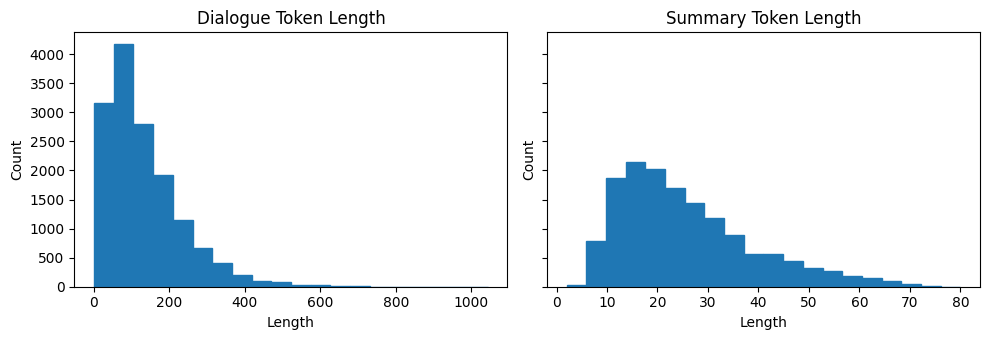

In [32]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [33]:
def convert_example_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_example_to_features, batched=True)

columns = ["input_ids", "attention_mask", "labels"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [34]:
# id teacher-forcing
# alt Decoder input and Label alignment for text generation
# caption decoder input and label alignement for text generation

text = ["PAD", "Transformers", "are", "awesome", "for", "text", "summarization"]
rows = []
for i in range(len(text)-1):
    rows.append({"step": i+1, "decoder_input": text[i+1], "label": text[i+1]})

pd.DataFrame(rows).set_index("step")

,decoder_input,label
step,,
1,Transformers,Transformers
2,are,are
3,awesome,awesome
4,for,for
5,text,text
6,summarization,summarization


In [49]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [50]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)


In [51]:
from huggingface_hub import notebook_login

notebook_login()

In [52]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [54]:
trainer.train()
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric,
                                   trainer.model, tokenizer, batch_size=2,
                                   column_text="dialogue",
                                   column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 410/410 [14:41<00:00,  2.15s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.400945,0.183557,0.318135,0.318053


In [55]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.400945,0.183557,0.318135,0.318053


In [56]:
trainer.push_to_hub("Training complete !")

events.out.tfevents.1702279261.ef3b6db8a29d.251.0:   0%|          | 0.00/9.62k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

events.out.tfevents.1702279733.ef3b6db8a29d.251.1:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

'https://huggingface.co/MohamedAE/pegasus-samsum/tree/main/'

### Generating Dialogue Summaries

In [57]:
import transformers

transformers.logging.set_verbosity_error()

In [61]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="MohamedAE/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary: ")
print(reference)
print("\nModel Summary: ")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary: 
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary: 
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [62]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""

print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.
